# Imports

In [1]:
from FOM import *
from ROM import *
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
np.random.seed(0)

# Experiment parameters

In [2]:
# Total number of independent initial conditions sampled (training + testing)
Ns = 50
# Proportion of Ns to be set aside for testing
testFrac = 0.3
# Time horizon
Tf = 5
# Number of nodes in the spatial grid 
N = 30
# Indices of the resolved variables
indices = [5, 10, 15, 20, 25]
# FOM object
FO  = FOM(N=N)
# Indices of the unresolved variabless
tildeindices = [i for i in range(FO.N) if i not in indices]
# Tolerance for solve_ivp to generate full-state snapshots
tol = 1e-12

# Cases with time-invariant PDE parameters and zero forcing

## (a) Advection only
$\mu = 0, \quad v=1, \quad a=0$.

In [3]:
mu = 0
v  = 1
a  = 0

Generate full-state snapshots and partition them into training and testing sets. The outputs here are dense interpolants in time $t$.

In [4]:
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=tol)

Reconstruct operators on a sample grid and predict resolved trajectories for unseen initial conditions.

In [5]:
# Build the time grid
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
# Full-state training snapshots on the grid
train = np.array([j(t_eval) for j in trainIP])
# Full-state testing snapshots on the grid
test = np.array([j(t_eval) for j in testIP])
# Split into resolved and unresolved variables
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
# Time derrivative of the resolved variables via finite-differences
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])
# ROM class
rom = ROM_Partial_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt)
# Learn the operators
rom.train(constantR=True)
# Predict trajectories of the resolved variables for testing initial conditions
sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], dt, Nt)
# Compute relative L2 error
err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
print(err)

1.7818665648342262e-11


Plot $||K(t)||_F$.

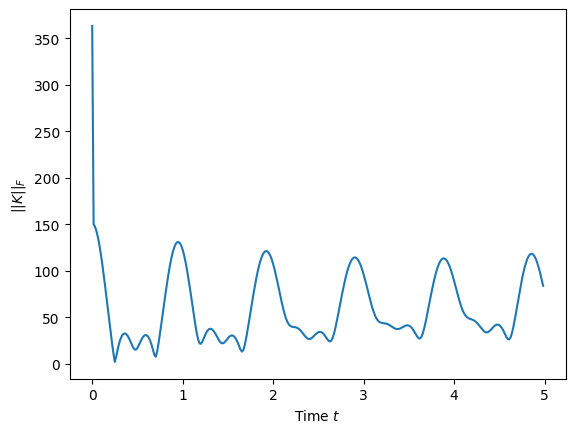

In [6]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

## (b) Advection dominated without reaction
$\mu = 0.1, \quad  v=1, \quad a = 0$.

In [9]:
mu = .1
v  = 1
a  = 0
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)


In [10]:
# Build the time grid
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
# Full-state training snapshots on the grid
train = np.array([j(t_eval) for j in trainIP])
# Full-state testing snapshots on the grid
test = np.array([j(t_eval) for j in testIP])
# Split into resolved and unresolved variables
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
# Time derrivative of the resolved variables via finite-differences
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])
# ROM class
rom = ROM_Partial_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt)
# Learn the operators
rom.train(constantR=True)
# Predict trajectories of the resolved variables for testing initial conditions
sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], dt, Nt)
# Compute relative L2 error
err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
print(err)

1.7069310489828975e-12


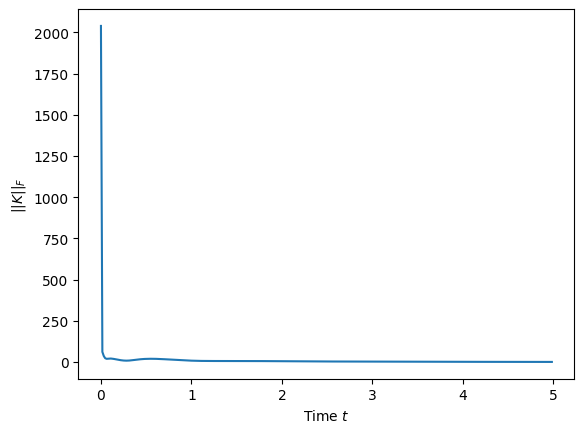

In [11]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

## (c) Reaction-diffusion-advection
$\mu = .05, \quad v=1, \quad a=1$

In [12]:
mu = 0.05
v  = 1
a  = 1
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)

In [13]:
# Build the time grid
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
# Full-state training snapshots on the grid
train = np.array([j(t_eval) for j in trainIP])
# Full-state testing snapshots on the grid
test = np.array([j(t_eval) for j in testIP])
# Split into resolved and unresolved variables
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
# Time derrivative of the resolved variables via finite-differences
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])
# ROM class
rom = ROM_Partial_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt)
# Learn the operators
rom.train(constantR=True)
# Predict trajectories of the resolved variables for testing initial conditions
sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], dt, Nt)
# Compute relative L2 error
err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
print(err)

1.9571944305240694e-12


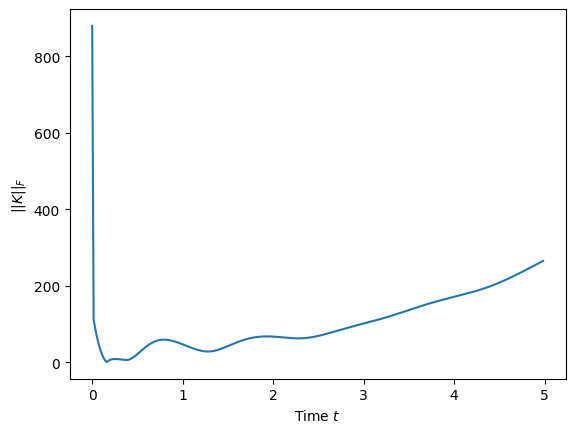

In [14]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

## (d) Diffusion dominated without reaction
$\mu = 2, \quad v=0.5, \quad a=0$

In [15]:
mu = 2
v  = 0.5
a  = 0
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)

In [16]:
# Build the time grid
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
# Full-state training snapshots on the grid
train = np.array([j(t_eval) for j in trainIP])
# Full-state testing snapshots on the grid
test = np.array([j(t_eval) for j in testIP])
# Split into resolved and unresolved variables
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
# Time derrivative of the resolved variables via finite-differences
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])
# ROM class
rom = ROM_Partial_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt)
# Learn the operators
rom.train(constantR=True)
# Predict trajectories of the resolved variables for testing initial conditions
sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], dt, Nt)
# Compute relative L2 error
err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
print(err)

4.6274031140222006e-12


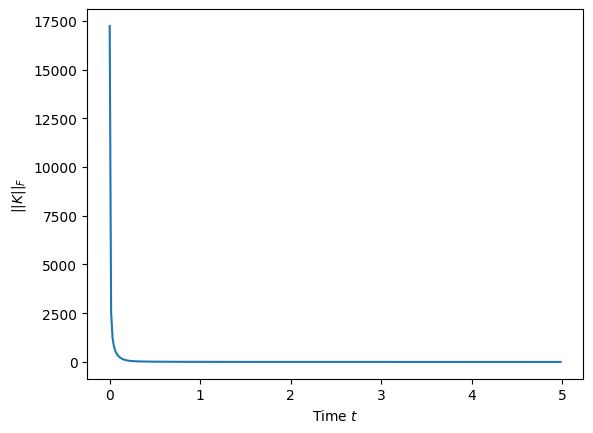

In [17]:
Knorms = [np.linalg.norm(rom.K[:,:,i]) for i in range(rom.K.shape[-1])]
plt.figure()
plt.plot(t_eval[:-1], Knorms)
plt.xlabel(r"Time $t$")
plt.ylabel(r"$||K||_F$")
plt.show()

# Cases with time-varying PDE parameters and zero forcing

##  (e) Time-depedent reaction-diffusion-advection
$\mu = 0.01\cos^2(2t), \quad v=1 + \sin^2(5t), \quad a=-0.5\cos t$

In [3]:
mu = lambda t: 0.01*np.cos(2*t)**2
v  = lambda t: 1 + np.sin(5*t)**2
a  = lambda t: -0.5*np.cos(t)

trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)

In [4]:
# Build the time grid
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
# Full-state training snapshots on the grid
train = np.array([j(t_eval) for j in trainIP])
# Full-state testing snapshots on the grid
test = np.array([j(t_eval) for j in testIP])
# Split into resolved and unresolved variables
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
# Time derrivative of the resolved variables via finite-differences
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])
# ROM class
rom = ROM_Partial_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt)
# Learn the operators
rom.train(constantR=False, regR=0, regK=0)
# Predict trajectories of the resolved variables for testing initial conditions
sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], dt, Nt)
# Compute relative L2 error
err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
print(err)

7.519465189790316e+118


In [8]:
reg = [0, 1e-8, 1e-4, 1e-2, 1]
errors = {}
for regR, regK in product(reg, reg):
        rom.train(constantR=False, regR=regR, regK=regK)
        sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], dt, Nt)
        err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
        errors[(regR, regK)] = err
# Prepare header
header = r"\beta_R \\ \beta_K | " + " | ".join(f"{k:>10.1e}" for k in reg)
print(header)
print("-" * len(header))
# Print each row
for regR in reg:
    row = f"{regR:>12.1e} | "
    for regK in reg:
        err = errors[(regR, regK)]
        row += f"{err:>10.2e} | "
    print(row)

\beta_R \\ \beta_K |    0.0e+00 |    1.0e-08 |    1.0e-04 |    1.0e-02 |    1.0e+00
-----------------------------------------------------------------------------------
     0.0e+00 |  7.52e+118 |   5.44e+27 |   8.78e+35 |   7.25e+22 |   2.10e+24 | 
     1.0e-08 |   5.59e-07 |   6.47e+20 |        inf |        inf |        inf | 
     1.0e-04 |   5.28e-07 |   1.15e-11 |   2.05e+26 |        inf |        inf | 
     1.0e-02 |   4.61e-07 |   1.15e-11 |   2.35e-04 |   2.78e+84 |        inf | 
     1.0e+00 |   4.07e-07 |   1.15e-11 |   2.33e-04 |   2.35e-02 |   3.07e-02 | 


## (f) Time-dependent reaction-advection
$\mu = 0, \quad v= 0.5 + \sin(4t),\quad  a=\cos(5t)^2,$

In [11]:
mu = 0
v  = lambda t: 0.5 + np.sin(4*t)
a  = lambda t: np.cos(5*t)**2
trainIP, testIP = FO.create_grand_data_tensor(Ns, Tf, mu, a, v, test_size=testFrac, atol=1e-12)

In [12]:
# Build the time grid
dt = 0.015625
Nt = int(Tf / dt)
t_eval = np.linspace(0, Tf, Nt + 1)
# Full-state training snapshots on the grid
train = np.array([j(t_eval) for j in trainIP])
# Full-state testing snapshots on the grid
test = np.array([j(t_eval) for j in testIP])
# Split into resolved and unresolved variables
PhiTrain, PhiTildeTrain = FO.split_matrix_by_columns(train, indices)
PhiTest, PhiTildeTest   = FO.split_matrix_by_columns(test, indices)
# Time derrivative of the resolved variables via finite-differences
PhiTrainDeriv = 1/dt * (PhiTrain[:,:,1:] - PhiTrain[:,:,0:-1])
# ROM class
rom = ROM_Partial_Data(PhiTrain, PhiTildeTrain, PhiTrainDeriv, dt)
# Learn the operators
rom.train(constantR=False, regR=0, regK=0)
# Predict trajectories of the resolved variables for testing initial conditions
sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], dt, Nt)
# Compute relative L2 error
err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
print(err)

163269637768682.78


In [13]:
reg = [0, 1e-8, 1e-4, 1e-2, 1]
errors = {}
for regR, regK in product(reg, reg):
        rom.train(constantR=False, regR=regR, regK=regK)
        sol = rom.solve(PhiTest[:,:,0], PhiTildeTest[:,:,0], dt, Nt)
        err = np.linalg.norm(sol - PhiTest)/np.linalg.norm(PhiTest)
        errors[(regR, regK)] = err
# Prepare header
header = r"\beta_R \\ \beta_K | " + " | ".join(f"{k:>10.1e}" for k in reg)
print(header)
print("-" * len(header))
# Print each row
for regR in reg:
    row = f"{regR:>12.1e} | "
    for regK in reg:
        err = errors[(regR, regK)]
        row += f"{err:>10.2e} | "
    print(row)

\beta_R \\ \beta_K |    0.0e+00 |    1.0e-08 |    1.0e-04 |    1.0e-02 |    1.0e+00
-----------------------------------------------------------------------------------
     0.0e+00 |   1.63e+14 |   1.47e+26 |   6.66e+26 |   5.03e+29 |   1.06e+29 | 
     1.0e-08 |   8.16e-07 |   2.89e+03 |   1.38e+30 |   1.37e+30 |   1.37e+30 | 
     1.0e-04 |   1.09e-06 |   1.48e-11 |   1.09e+11 |   3.68e+36 |   3.84e+39 | 
     1.0e-02 |   7.08e-07 |   1.48e-11 |   3.22e+17 |   1.94e+08 |   1.54e+25 | 
     1.0e+00 |   1.50e-06 |   1.48e-11 |   6.87e-04 |   3.97e-02 |   1.96e-01 | 
